# `datasets_phenom`

In [ ]:
#| default_exp datasets_phenom

In [ ]:
#| export
from andi_datasets.models_phenom import models_phenom

import inspect
import numpy as np
import pandas as pd
import csv
from tqdm.auto import tqdm
import copy

import os
import warnings

In [ ]:
#| hide
import matplotlib.pyplot as plt
from nbdev import show_doc
from andi_datasets.utils_trajectories import plot_trajs
%load_ext autoreload
%autoreload 2

#| hide
# Class constructor

In [ ]:
#| export
class datasets_phenom():
    def __init__(self,
                models_class = models_phenom()):
            ''' 
            This class generates, saves and loads datasets of trajectories simulated from various phenomenological diffusion models (available at andi_datasets.models_phenom). 
            '''
            self.models_class = models_class
            self._get_models()
        
    def _get_models(self):        
        '''Loads the available models from the subclass'''

        available_models = inspect.getmembers(self.models_class, inspect.ismethod)      
        available_models = available_models[1:][::-1] # we need this to get rid of the init
        self.avail_models_name = [x[0] for x in available_models]
        self.avail_models_func = [x[1] for x in available_models]
        
    def _get_inputs_models(self, model, get_default_values = False):
        
        model_f = self.avail_models_func[self.avail_models_name.index(model)] 
        defaults = inspect.getfullargspec(model_f).defaults
        params = inspect.getfullargspec(model_f).args[1:]
        if get_default_values:
            return params, defaults
        else:
            return params
        
    def _get_states(self):
        ''' Definition of the possible states found in the ANDI 2 challenge (phenom) and their 
        assigned label:
        0: immobile; 1: confined; 2: brownian; 3: anomalous '''
        
        self._states = ['immobile', 'confined', 'brownian', 'anomalous']
        

#| hide
# `create_dataset`

In [ ]:
#| hide

#| export

class datasets_phenom(datasets_phenom):
                
    def create_dataset(self,
                       dics: list|dict|bool = False,
                       T: None|int = None,
                       N_model: None|int = None,  
                       path: str = '',
                       save: bool = False,
                       load: bool = False):
        ''' 
        Given a list of dictionaries, generates trajectories of the demanded properties.
        The only compulsory input for every dictionary is 'model', i.e. the model from which 
        trajectories must be generated. The rest of inputs are optional.
        You can see the input parameters of the different models in andi_datasets.models_phenom,
        This function checks and handles the input dataset and the manages both the creation,
        loading and saving of trajectories.
        
        Parameters
        ----------
        dics : list, dictionary, bool
            - if list or dictionary: the function generates trajectories with the properties stated in each dictionary.
            - if bool: the function generates trajectories with default parameters set for the ANDI 2 challenge (phenom) for every available diffusion model.
        T : int, None
            - if int: overrides the values of trajectory length in the dictionaries.
            - if None: uses the trajectory length values in the dictionaries. 
            Caution: the minim T of all dictionaries will be considered!
        N_model : int, None
            - if int: overrides the values of number of trajectories in the dictionaries.
            - if None: uses the number of trajectories in the dictionaries
        save : bool
            If True, saves the generated dataset (see self._save_trajectories).
        load : bool
            If True, loads a dataset from path (see self._load_trajectories).
        path : str
            Path from where to save or load the dataset.
            
        Returns
        -------
        tuple
            - trajs (array TxNx2): particles' position. N considers here the sum of all trajectories generated from the input dictionaries. 
            - labels (array TxNx2): particles' labels (see ._multi_state for details on labels) 
        '''
        
        self.T = T
        self.N_model = N_model
        self.path = path
        self.dics = dics
        
        '''Managing dictionaries'''
        # If the input is a single dictionary, transform it to list
        if isinstance(self.dics, dict): self.dics = [self.dics]
        # if dics is False, we select trajectories from all models with default values
        if self.dics is False: self.dics = [{'model': model} for model in self.avail_models_name]

                    
        '''Managing folders of the datasets'''  
        self.save = save
        self.load = load
        if self.save or self.load:                
            if self.load:
                self.save = False            
            if not os.path.exists(self.path) and self.load:
                raise FileNotFoundError('The directory from where you want to load the dataset does not exist')                
            if not os.path.exists(self.path) and self.save:
                os.makedirs(self.path) 
                
                
        '''Create trajectories'''
        trajs, labels = self._create_trajectories()
        
        return trajs, labels                        

In [ ]:
show_doc(datasets_phenom().create_dataset, name = 'create_dataset')

In the example below we create two dictionaries and generate a dataset with it. See the corresponding tutorial for more details.

False
False


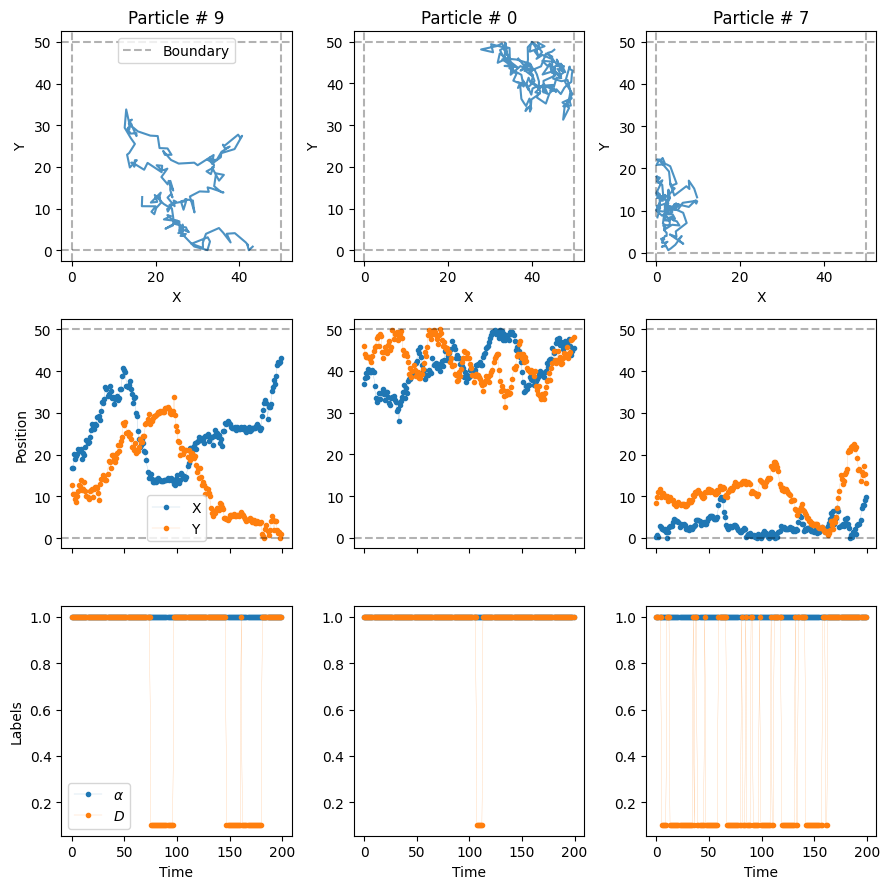

In [ ]:
L = 50
dict_model3 = {'model': 'dimerization', 
               'L': L,
               'Pu': 0.1, 'Pb': 1}
dict_model5 = {'model': 'confinement',
               'L': L, 
               'trans': 0.2}

dict_all = [dict_model3, dict_model5]

trajs, labels = datasets_phenom().create_dataset(N_model = 10, # number of trajectories per model
                                                 T = 200,
                                                 dics = dict_all
                                                )
plot_trajs(trajs, L , N = 10, 
           num_to_plot = 3,
           labels = labels,
           plot_labels = True
          )

# Creating, saving and loading trajectories
These auxiliary functions used in `create_trajectories` that allow for manipulate trajectories in various forms.

In [ ]:
#| export
#| hide
class datasets_phenom(datasets_phenom):   
    
    def _create_trajectories(self): 
        ''' 
        Given a list of dictionaries, generates trajectories of the demanded properties.
        First checks in the .csv of each demanded model if a dataset of similar properties exists. 
        If it does, it loads it from the corresponding file.       
        
        Returns
        ----------
        tuple
            data_t  array containing the generated trajectories
            data_l  array containing the corresponding labels.
        '''

        for dic in copy.deepcopy(self.dics):
            
            df, dataset_idx = self._inspect_dic(dic)
            
            # If the dataset does not yet exists
            if dataset_idx is False:
                # Retrieve name and function of diffusion model
                model_f = self.avail_models_func[self.avail_models_name.index(dic['model'])]
                # Create dictionary with only arguments
                dic_args = dict(dic); dic_args.pop('model')
                
                trajs, labels = model_f(**dic_args)
                
                # Save the trajectories if asked
                if self.save:
                    self._save_trajectories(trajs = trajs,
                                            labels = labels,
                                            dic = dic, 
                                            df = df,
                                            dataset_idx = dataset_idx,
                                            path = self.path)                    
            else:
                trajs, labels = self._load_trajectories(model_name = dic['model'],
                                                        dataset_idx = dataset_idx,
                                                        path = self.path)
                
            # Stack dataset
            try:
                data_t = np.hstack((data_t, trajs))                    
                data_l = np.hstack((data_l, labels))
            except:
                data_t = trajs
                data_l = labels
                    
        return data_t, data_l  
    
    def _save_trajectories(self, trajs, labels, dic, df, dataset_idx, path):
        ''' 
        Given a set of trajectories and labels, saves two things:        
            - In the .csv corresponding to the demanded model, all the input parameters of the generated dataset. This allows to keed that of what was created before.
            - In a .npy file, the trajectories and labels generated.
        '''
        
        file_name = path+dic['model']+'_'+str(df.shape[0])+'.npy'
        
        # Save information in CSV handler
        df = df.append(dic, ignore_index = True) 
        #print(dic)
        #df = pd.concat([df, 
        #                pd.DataFrame(dic)], 
        #               ignore_index=True)        
        df.to_csv(path+dic['model']+'.csv')
        
        # Save trajectories and labels
        data = np.dstack((trajs, labels))
        np.save(file_name, data)
        
    def _load_trajectories(self, model_name, dataset_idx, path):
        ''' 
        Given the path for a dataset, loads the trajectories and labels
        '''
        
        file_name = path+model_name+'_'+str(dataset_idx)+'.npy'
        data = np.load(file_name)
        return data[:, :, :2], data[:, :  , 2:]
    

In [ ]:
show_doc(datasets_phenom._create_trajectories, name = '_create_trajectories')

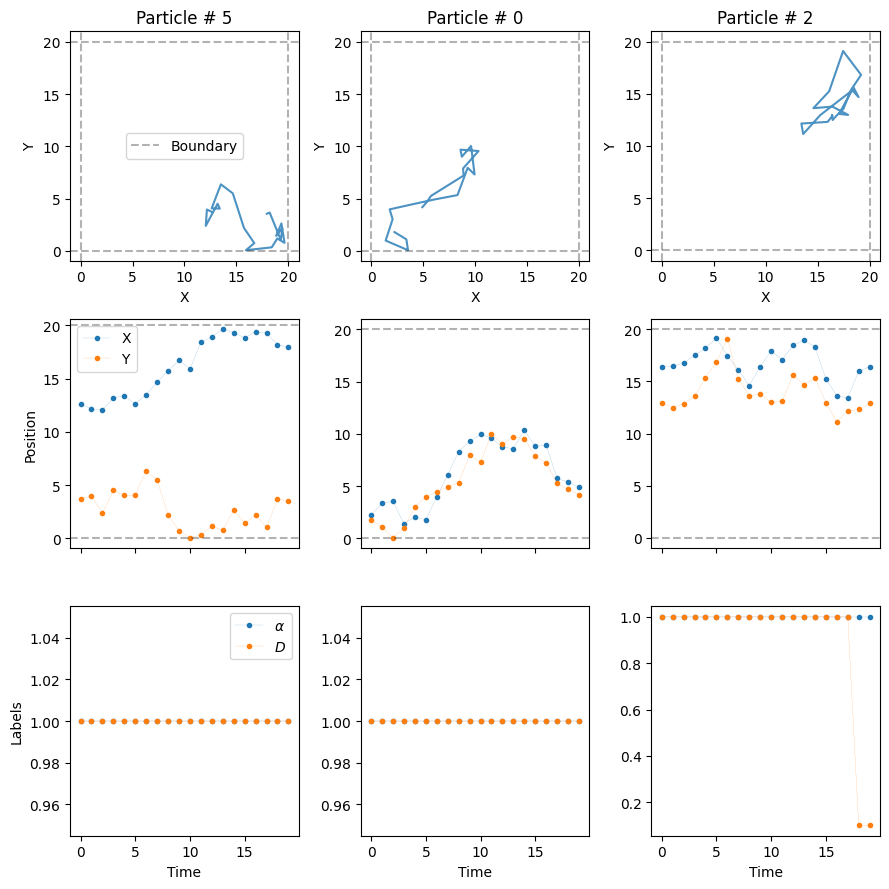

In [ ]:
L = 20
dict_1 = {'model': 'multi_state', 
               'L': L}
dict_2 = {'model': 'immobile_traps', 
               'L': L}
dict_all = [dict_1, dict_2]

DP = datasets_phenom()
trajs, labels = DP.create_dataset(N_model = 10, # number of trajectories per model
                                 T = 20,
                                 dics = dict_all                                            
                                )
plot_trajs(trajs, L , N = 10, 
           num_to_plot = 3,
           labels = labels,
           plot_labels = True
          )

In [ ]:
show_doc(datasets_phenom._save_trajectories, name = '_save_trajectories')

C:\Users\Gorka\AppData\Local\Temp\ipykernel_11608\369869117.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dic, ignore_index = True)
C:\Users\Gorka\AppData\Local\Temp\ipykernel_11608\369869117.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dic, ignore_index = True)


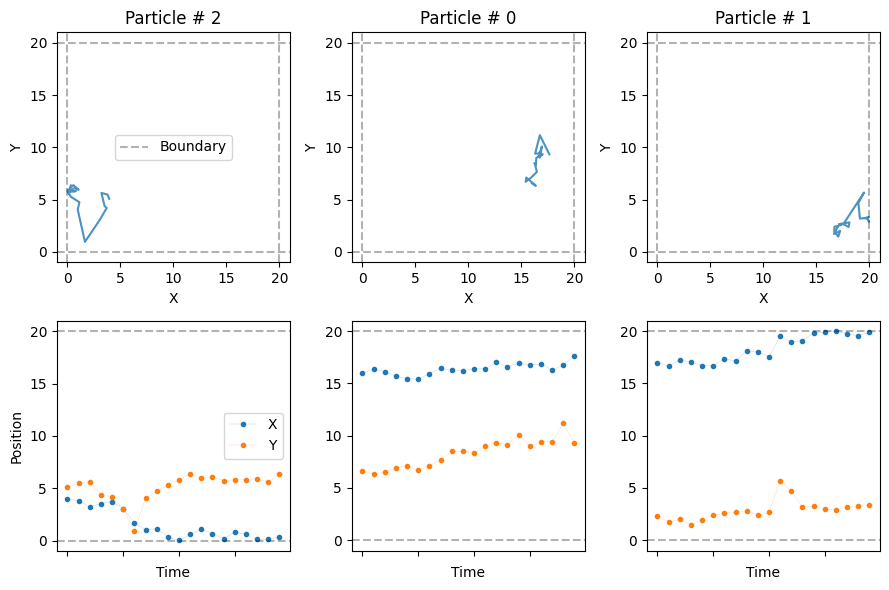

In [ ]:
trajs, labels = DP.create_dataset(N_model = 10, # number of trajectories per model
                                     T = 20,
                                     dics = dict_all,
                                     save = True, path = 'datasets_folder/'
                                    )
plot_trajs(trajs, L , N = 3)

In [ ]:
show_doc(datasets_phenom._load_trajectories, name = '_load_trajectories')

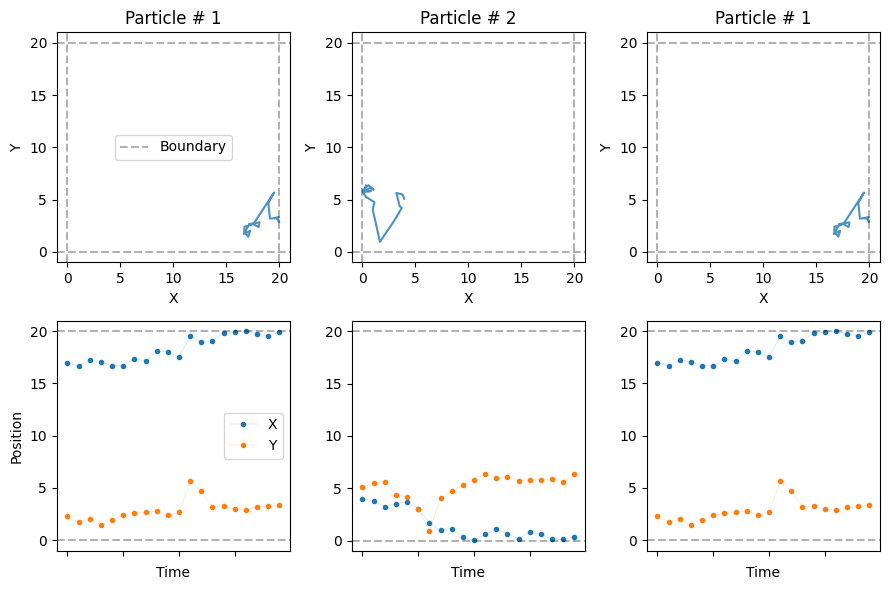

In [ ]:
# You must run to cells above for this one to work. Check that this are the 
# exact same trajectories.
trajs, labels = DP.create_dataset(N_model = 10, # number of trajectories per model
                                                 T = 20,
                                                 dics = dict_all[0],
                                                 load = True, path = 'datasets_folder/'
                                                )
plot_trajs(trajs, L , N = 3 )

# Managing parameters and dictionaries

#| hide
# `_inspect_dic`
Given a dictionary, this function checks that it fulfils the constraints of the program and checks the validity of the save/load actions.

In [ ]:
#| export
#| hide
class datasets_phenom(datasets_phenom):   

    def _inspect_dic(self, dic):
        '''        
        Checks the information of the input dictionaries so that they fulfil the constraints of the program , completes missing information
        with default values and then decides about loading/saving depending on parameters.
        
        Parameters
        ----------
        dic : dict
            Dictionary with the information of the trajectories we want to generate
        
        Returns
        -----------
        tuple
            df: dataframe collecting the information of the dataset to load.
            dataset_idx: location in the previous dataframe of the particular dataset we want to generate.
            
        '''        
            
        # Add time and number of trajectories information
        if self.N_model is not None:
            dic['N'] = self.N_model
        if self.T is not None:
            dic['T'] = self.T

        # Check if CSV with information of dataset exists. If not, create it
        model_m = dic['model']
        model_f = self.avail_models_func[self.avail_models_name.index(model_m)]    
        # Check arguments and defaults from model's function            
        args = inspect.getfullargspec(model_f).args[1:]
        defaults = inspect.getfullargspec(model_f).defaults
        try:
            df = pd.read_csv(self.path+model_m+'.csv', index_col=0)
        except:                
            # convert to dataframe and add model
            df = pd.DataFrame(columns = args+['model'])   
        # Assign missing keys in dic with default values
        for arg, default in zip(args, defaults):
            if arg not in dic.keys():
                dic[arg] = default

        # Check if updated keys of dic equal keys of csv.
        if set(list(df.keys())) != set(list(dic.keys())):
            raise ValueError('Input model dictionary does not match models properties')

        # Check if the dataset already exists:
        df_conditions = df.copy()
        # Nones in dataframes are transformed into Nans. We change back this here
        # but instead of putting None, we put False.
        df_conditions = df_conditions.where(pd.notnull(df_conditions), False)
        for key in dic:
            # Transforming Nones to False in variables dictionaries (see problem with df just above) 
            if dic[key] is None: dic[key] = False
            # We need to transform it to str to do a fair comparison between matrices (e.g. transition matrix, Ds, alphas,...)
            df_conditions = df_conditions.loc[(df_conditions[key].astype(str) == str(dic[key]))]
            if len(df_conditions.index) == 0:                
                break
        
        
        # If dataset exists
        if len(df_conditions.index) > 0:
            # if the dataset exists and save was True, do not save but load
            if self.save:
                wrn_str = f'The dataset you want to save already exists (file: {model_m}_{df_conditions.index[0]}.npy). Switching to Load mode.'
                warnings.warn(wrn_str)
                dataset_idx = df_conditions.index[0] 
            elif self.load:
                dataset_idx = df_conditions.index[0]
            else:
                dataset_idx = False                 

        # If dataset does no exists
        else:         
            if self.load:
                raise ValueError('The dataset you want to load does not exist.')
            else: # If the dataset does not exist, append empty string.
                # This allows to mix saving and loading
                dataset_idx = False
                
        return df, dataset_idx

In [ ]:
df = pd.read_csv('datasets_folder/immobile_traps.csv', index_col=0)

In [ ]:
df

,N,T,L,r,Pu,Pb,Ds,alphas,Nt,traps_pos,deltaT,model
0,10,20,10,1,0.1,0.01,"[1, 0]","[1, 0]",10,NaN,1,immobile_traps


In [ ]:
df.fillna('',inplace=True)

In [ ]:
pd.notnull(df)

,N,T,L,r,Pu,Pb,Ds,alphas,Nt,traps_pos,deltaT,model
0,True,True,True,True,True,True,True,True,True,False,True,True


In [ ]:
df_conditions = df.where(pd.notnull(df), None)

In [ ]:
df_conditions['traps_pos']

0   NaN
Name: traps_pos, dtype: float64

In [ ]:
dictm = {'model': 'immobile_traps', 
               'L': 10}


DP = datasets_phenom()
DP.N_model = 10
DP.T = 20
DP.load = True
DP.save = False
DP.path = 'datasets_folder/'

In [ ]:
DP._inspect_dic(copy.deepcopy(dictm))

(    N   T   L  r   Pu    Pb      Ds  alphas  Nt  traps_pos  deltaT  \
 0  10  20  10  1  0.1  0.01  [1, 0]  [1, 0]  10        NaN       1   
 
             model  
 0  immobile_traps  ,
 0)

In [ ]:
show_doc(datasets_phenom._inspect_dic, name = '_inspect_dic')

#| hide
# `_get_args`
Given the name of a model, returns its input parameters

In [ ]:
#| export
#| hide
class datasets_phenom(datasets_phenom):  
    def _get_args(self, model, return_defaults = False):
        ''' 
        Given the name of a diffusion model, return its inputs arguments.
        
        Parameters
        ----------
        model : str
            Name of the diffusion model (see self.available_models_name)
        return_defaults : bool
            If True, the function will also return the default values of each input argument.
            
        Returns
        -------
        tuple
            args (list): list of input arguments.
            defaults (optional, list): list of default value for the input arguments.
        '''
        model_f = self.avail_models_func[self.avail_models_name.index(model)]    
        # Check arguments and defaults from model's function            
        args = inspect.getfullargspec(model_f).args[1:]
        defaults = inspect.getfullargspec(model_f).defaults
        if return_defaults:
            return args, defaults
        else:
            return args

In [ ]:
show_doc(datasets_phenom._get_args, name = '_get_args')

#| hide
# NBDEV Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()